# Gaia DR3 Hackathon @ MIT
# Action-Angle Coordinates Tutorial

In this tutorial, we will use Agama to compute the *action-angle coordinates*. 

## Definition

- The instantaneous state of each star is given by its **phase space** coordinate, which consists of the 3 spatial coordinates and 3 momenta $(\vec{x}, \vec{p}=m\vec{v})$. 

- Because $(\vec{x}, \vec{p})$ change as a function of time $t$, they are sometimes not helpful for understanding the orbits of the stars.

- Instead, we opt to characterize an orbit using its **integrals of motion**, which usually stay constant.

- In Hamiltonian mechanics, for systems with period equation of motions (such as the Milky Way), we replace the momenta with the **action variable**, defined by the integral:

 \begin{equation}
    J_i \equiv \oint p_i d x_i
 \end{equation}
 
 where, for each pair of coordinate $(x_i, p_i)$, the integral is taken over one complete period of oscillation.
 We see that the action $J_i$ has the same unit with angular momentum, which is $\mathrm{length}^2/\mathrm{time}$.

- Intuitively, the actions describe the extent of oscillations in each dimension.

- The coordinate conjugate to $J_i$ is the **angle variable**, related to $J_i$ via the Hamiltonia equation:

 \begin{equation}
     \dot{\theta}_i = \frac{\partial \mathcal{H}}{\partial J_i} = \mathrm{constant}
 \end{equation}
 
 according to the Hamiltonia-Jacobi formalism. $\mathcal{H}$ is the Hamiltonian of the system.
 
- Together $\vec{\theta}$ and $\vec{J}$ form a pair of **canonical coordinates** equivalent to $\vec{x}$ and $\vec{p}$.

<div>
<img src="images/action_angle.png" width="350"/>
</div>
<center> 
Visualization of the action-angle variables in the position-momentum phase space.
Credit: <a href="http://eugvas.net/teaching/dynamics_cambridge2022/lec5_actions.pdf">Lecture Note by Eugene Vasiliev</a>.
</center>

## Galaxy Formation

- Galaxies form hierarchically via mergers of smaller satellite galaxies.

- During a merger event, stars are tidally stripped from a satellite galaxy and stretched out along their orbits into stellar streams and debris flows. 

- The Milky Way halo contains traces of old and recent accretion events.

- Actions $\vec{J}$ are **adiabatic invariants**: they are conserved under a slowly changing potential. This is a reasonable approximation for the potential of the Milky Way (even during a merger). 

- Because stars from the same satelite galaxies tend to cluster in action-space but sometimes not in position- and velocity- space, the actions is a useful tool to identify accreted stars.


<div>
<img src="images/Milky-Way-merger-tree.jpg" width="800"/>
</div>
<center> 
The "merger tree" of the Milky Way.
Credit: <a href="https://academic.oup.com/mnras/article/498/2/2472/5893320?login=true">Kruijssen et al. 2020</a>.
</center>

## Summary

- Action-angle variables $(\vec{J}, \vec{\theta})$ are often used to describe motions of periodic systems such as orbits of stars in the Milky Way.

- Actions $\vec{J}$ have a clear physical meaning: they describe the extent of oscillations in their dimension.

- Angles $\vec{\theta}$ naturally describe the motion and also change linearly with time.

- Actions $\vec{J}$ are **adiabatic invariants**, making them useful when studying the process of galaxy accretion in the Milky Way. 

## Resources:

- [Lecture Note by Douglas Cline](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_(Cline)/15%3A_Advanced_Hamiltonian_Mechanics/15.05%3A_Action-angle_Variables)

- [Lecture Note by Eugene Vasiliev](http://eugvas.net/teaching/dynamics_cambridge2022/lec5_actions.pdf)

- [MIT OWC 8.09 Lecture Note](https://ocw.mit.edu/courses/8-09-classical-mechanics-iii-fall-2014/f00f7f68ac7ba346a0868efb7430582c_MIT8_09F14_Chapter_4.pdf)

- [*Galactic Dynamics: Second Edition* by James Binney and Scott Tremaine](https://www.amazon.com/Galactic-Dynamics-Second-Princeton-Astrophysics/dp/0691130272)


In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import HTML, display

import agama

%matplotlib inline

# Set unit of Agama to (mass, length, velocity) = (1 Msun, 1 kpc, 1 km/s)
agama.setUnits(mass=1, length=1, velocity=1)

plt.style.use('seaborn-colorblind')
mpl.rcParams.update({
    'font.size': 18,
    'figure.figsize': (8, 6),
    'figure.facecolor': 'w',
    'axes.linewidth': 2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

## Milky Way Potential
Because the action-angle coordinates are integrals of motions, to estimate them, we have to trace the orbit of each star (via a process called *orbit integration*).
Orbit integration requires knowledge of the potential $\Phi$ of the Milky Way.
We assume a static potential (constant in time) and use the `MWPotential2014` model described in [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf).


In [Bovy 2014](https://arxiv.org/pdf/1412.3451.pdf), the Milky Way potential is estimate to made up of three main components: a dark matter halo, a spherical bulge, and a disk (see schematic below):

<div>
<img src="images/Milky-Way-structure.png" width="450"/>
</div>
<center> 
A schematic of the Milky Way. 
Credit: CalPoly <a href="https://evolution.calpoly.edu/milky-way-galaxy">https://evolution.calpoly.edu/milky-way-galaxy</a>
</center>


- **Dark Matter Halo**: described by a Navarro-Frenk-White (NFW) spherical density profile

 \begin{equation}
    \rho_\mathrm{halo}(r) = \left(8.49 \times 10^6 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \left(\frac{r}{16 \, \mathrm{kpc}}\right)^{-1} 
    \left(1 + \frac{r}{16 \, \mathrm{kpc}}\right)^{-2}
 \end{equation}

 where $r$ is the spherical radius.

- **Galactic Bulge**: described by a power-law density with an exponential cut-off

 \begin{equation}
    \rho_\mathrm{bulge}(r) = \left(2.23 \times 10^8 \, \frac{\mathrm{M_\odot}}{\mathrm{kpc^3}}\right) 
    \,\left(\frac{r}{1 \, \mathrm{kpc}}\right)^{-1.8}\,\exp\left[-\left(\frac{r}{1.9 \, \mathrm{kpc}}\right)^2\right]
 \end{equation}

 where $\rho_1$ is the central density, $r_1$ is the scale radius, and $r_c$ is the cut-off radius.
 The potential of the bulge may be calculated from the enclosed mass $M_\mathrm{enc}(r)$

 \begin{equation}
    \Phi_\mathrm{spherioid}(r) = - \frac{G M_\mathrm{enc}(r)}{r}, 
    \quad \mathrm{where} \quad 
    M_\mathrm{enc}(r) = \int_0^r \rho(\mathrm{\tilde{r}}) \, 4\pi \tilde{r}^2 \, d\tilde{r}
 \end{equation}


- **Disk**: described by the Miyamoto-Nagai potential model ([Miyamoto & Nagai 1975](https://ui.adsabs.harvard.edu/abs/1975PASJ...27..533M/abstract)):

 \begin{equation}
    \Phi_\mathrm{disk}(R, z) = - \frac{GM}{\sqrt{R^2 + \left(\sqrt{z^2 + b^2} + a\right)^2}}
 \end{equation}

 where $R$ is the cylindrical radius, $z$ is the height, $M=6.82 \times 10^{10} \, M_\odot$ is the total mass of the disk, $b=0.28 \, \mathrm{kpc}$ is the scale height, and $a = 3 \, \mathrm{kpc}$ is the scale length.

In [2]:
# Read in the potential of the Milky Way
potential = agama.Potential(file='mw_potentials/MWPotential2014.ini')

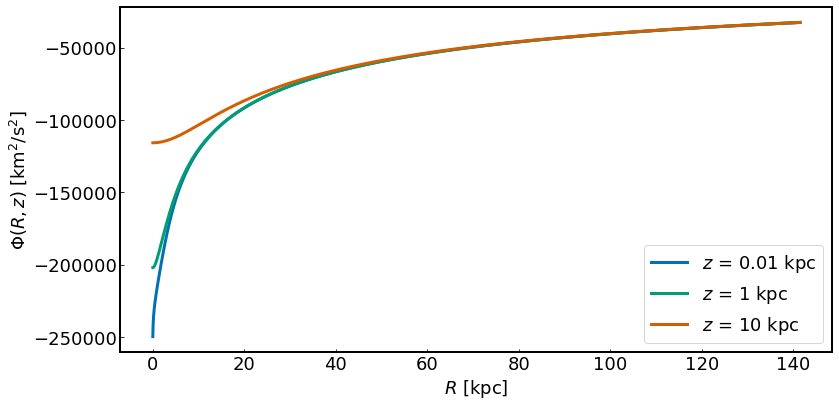

In [3]:
# Plot the potential at different cylindrical radius and different height
fig, ax = plt.subplots(1, figsize=(12, 6))

r_max = 50
X = np.logspace(-2, 2, 500)
Y = np.logspace(-2, 2, 500)
R = np.sqrt(X**2 + Y**2)

for z in [0.01, 1, 10]:
    Z = np.ones_like(X) * z
    simulated_pos = np.stack([X, Y, Z], axis=1)    
    pot = potential.potential(simulated_pos)
    ax.plot(R, pot, label=f'$z$ = {z} kpc', lw=3)
    
ax.set_ylabel(r'$\Phi(R, z) \; [\mathrm{km}^2 / \mathrm{s}^2]$')
ax.set_xlabel('$R$ [kpc]')
ax.legend(loc=4)

fig.tight_layout()

We may also plot the rotational velocity $v_\mathrm{rot}(R)$ at a given height $z$ ($R$ is the cylindrical radius).
The rotational velocity is defined as:

\begin{equation}
    v_\mathrm{rot}^2(R) = F_\mathrm{rot} R = \frac{\partial \Phi(R, z)}{\partial R} R
\end{equation}

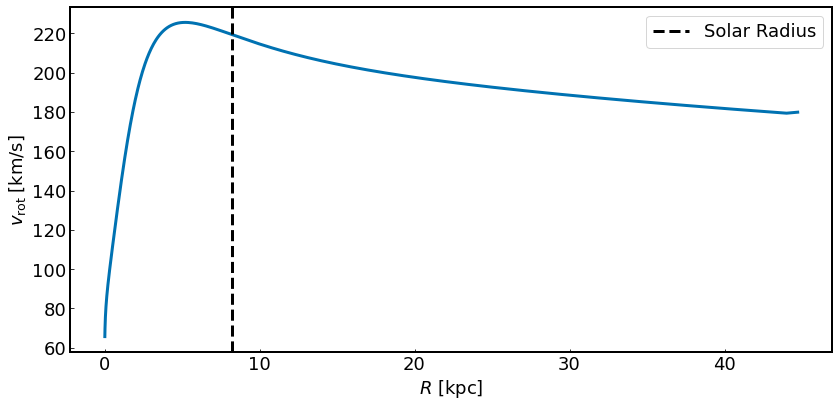

In [4]:
# Plot the rotation curve given by this potential at z=0
fig, ax = plt.subplots(1, figsize=(12, 6))

r_max = 50
X = np.logspace(-2, 1.5, 500)
Y = np.logspace(-2, 1.5, 500)
Z = np.zeros_like(X) 
R = np.sqrt(X**2 + Y**2)

# Calculate the rotation velocity defined by
# v^2 = (dPhi / dR) * R
simulated_pos = np.stack([X, Y, Z], axis=1)    
vrot = np.sqrt(np.gradient(potential.potential(simulated_pos), R) * R)
ax.plot(R, vrot, lw=3)
ax.axvline(8.2, color='k', lw=3, ls='--', label='Solar Radius')

ax.set_ylabel(r'$v_\mathrm{rot} \; [\mathrm{km} / \mathrm{s}]$')
ax.set_xlabel('$R$ [kpc]')
ax.legend()

fig.tight_layout()

In the `mw_potentials` directory, you may find more `.ini` files from different studies that fit the Milky Way potential. 
Feel free to experiment with different potential models and see how your results change. 

## 1. Orbit Integration

With the potential, we may now perform orbit integration.

### Example: Orbit of the Sun

In this example, we will use Agama to integrate the orbit of the Sun around the Galactic center. To do this, we need the initial positions and velocities of the Sun. We set these to:

\begin{equation}
    (x, y, z) = (8.2, \; 0, \; 0) \, \mathrm{kpc} \\
    (v_x, v_y, v_z) = (20.3801, \; 224.7092, \; 3.8954) \, \mathrm{km/s}
\end{equation}

In [5]:
# Initial position and velocities of the Sun
posvel = np.array([[8.2, 0, 0, 20.3801, 224.7092, 3.8954]])

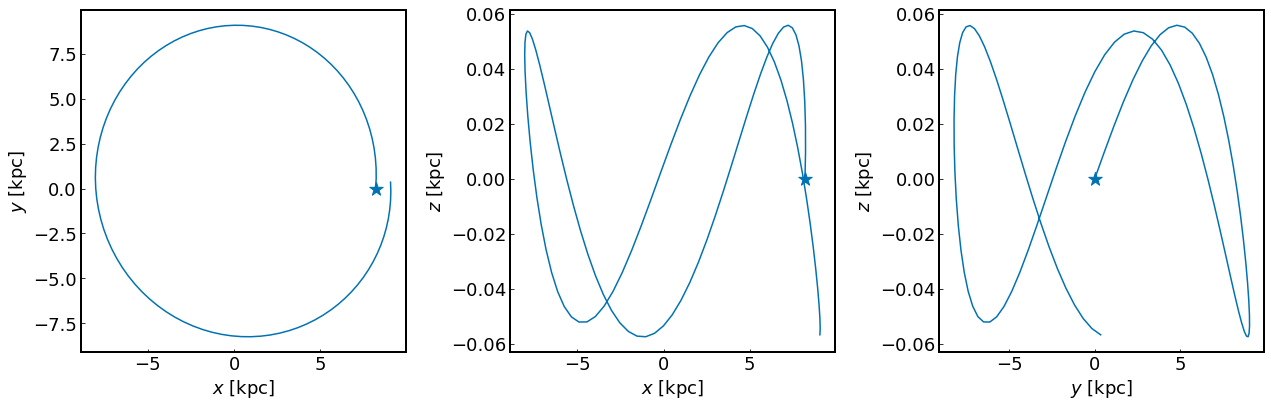

In [6]:
# Integrate and plot the orbit for 250 Million years
times, orbit = agama.orbit(
    ic=posvel, potential=potential, time=0.25, trajsize=100)[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].scatter(posvel[0, 0], posvel[0, 1], marker="*", s=200)
axes[1].scatter(posvel[0, 0], posvel[0, 2], marker="*", s=200)
axes[2].scatter(posvel[0, 1], posvel[0, 2], marker="*", s=200)

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

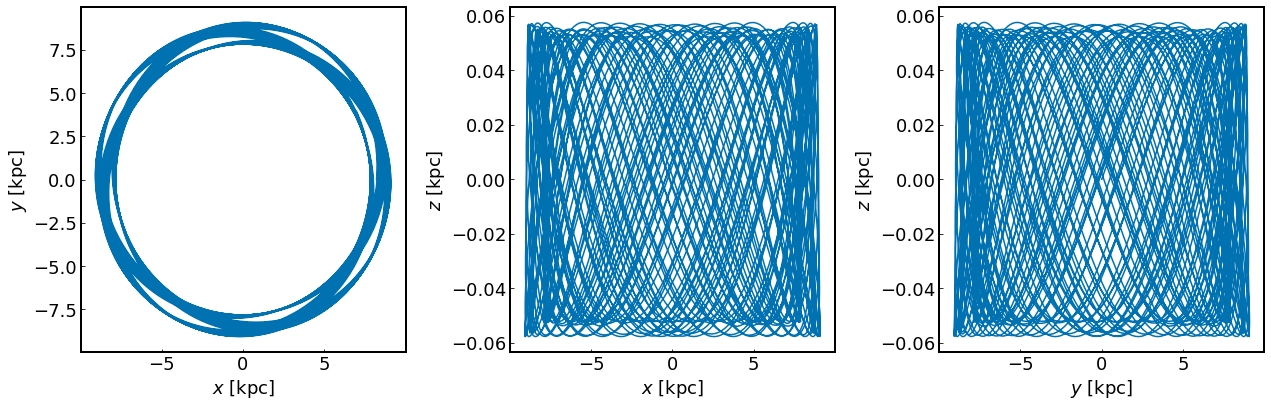

In [7]:
# Integrate and plotthe orbit for 10 Billion years
times, orbit = agama.orbit(
    ic=posvel, potential=potential, time=10, trajsize=10000)[0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

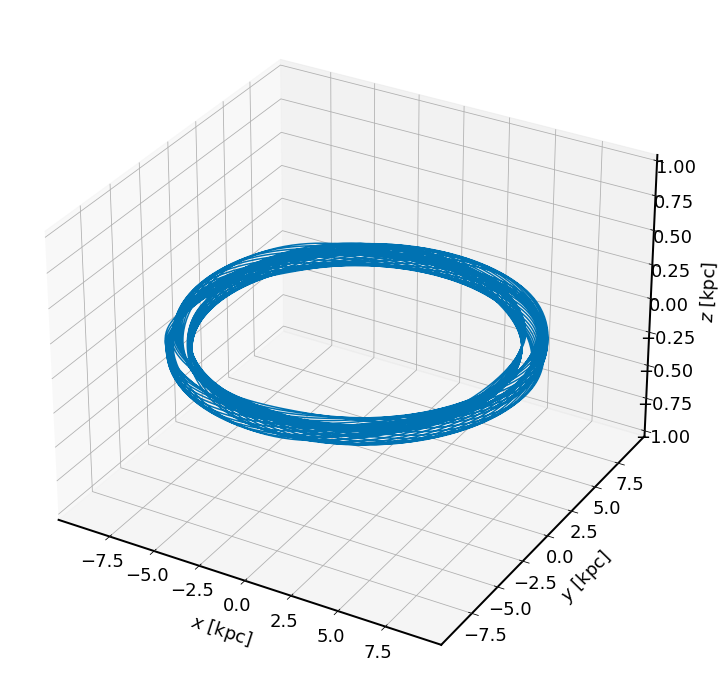

In [8]:
# Plot 3D orbit
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.plot3D(orbit[:, 0], orbit[:, 1], orbit[:, 2])
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_zlim3d(-1, 1)

fig.tight_layout()

### Example: Orbit of a star with a radial orbit

What if the Sun is falling radially towards the Galactic center instead of orbitin around it? To test this out, we switch the initial $v_x$ and $v_y$ velocities and use Agama to integrate the orbit.

\begin{equation}
    (x, y, z) = (8.2, \; 0, \; 0) \, \mathrm{kpc} \\
    (v_x, v_y, v_z) = (224.7092,  \; 20.3801, \; 3.8954) \, \mathrm{km/s}
\end{equation}

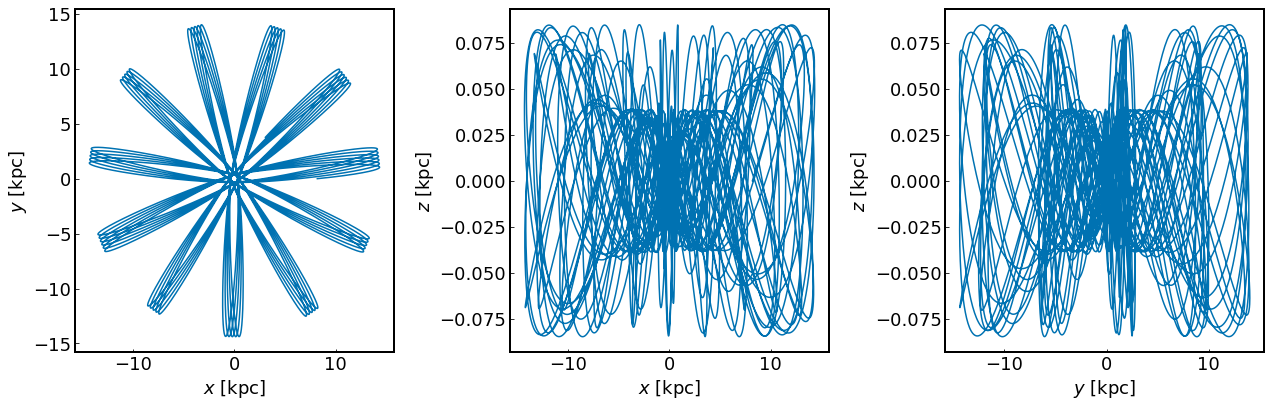

In [9]:
posvel = np.array([[8.2, 0, 0, 224.7092, 20.3801, 3.8954]])

# Integrate and plotthe orbit for 10 Billion years
times, orbit = agama.orbit(
    ic=posvel, potential=potential, time=10, trajsize=10000)[0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

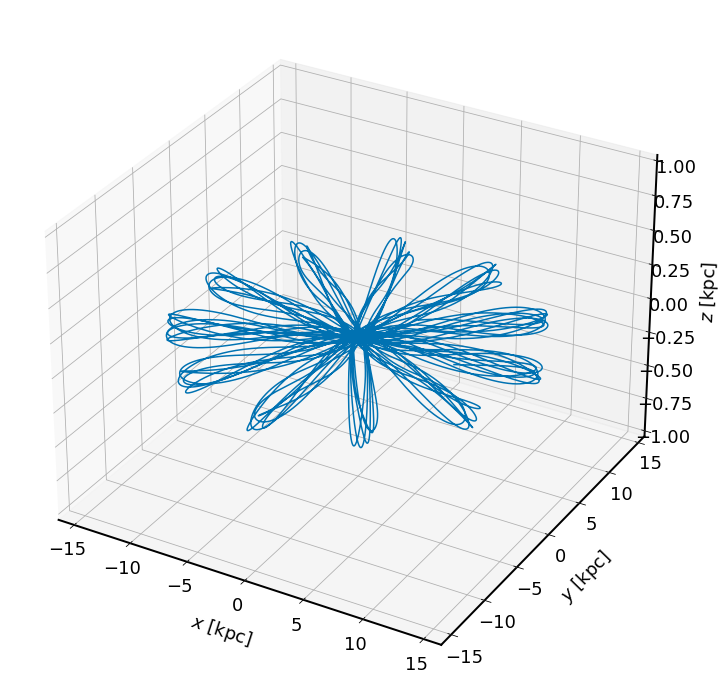

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.plot3D(orbit[:, 0], orbit[:, 1], orbit[:, 2])
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_zlim3d(-1, 1)

fig.tight_layout()

### Example: Orbits of accreted stars

In this example, we will integrate the orbit of a number of accreted stars and compare it to the solar orbit.

In [11]:
# Read in accreted stars data in CSV format
data = pd.read_csv("data.csv")

# read in ICRS coordinates with unit
# convert parallax to distance
ra = data['ra'].values * u.deg
dec = data['dec'].values * u.deg
parallax = data['parallax'].values * u.mas
rv = data['radial_velocity'].values * u.km / u.s
pmra = data['pmra'] * u.mas / u.yr
pmdec = data['pmdec'] * u.mas / u.yr

dist = coord.Distance(parallax=parallax)

# coordinate transformation with astropys
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, 
    pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
gal = icrs.transform_to(coord.Galactocentric())

In [12]:
# Integrate and plot the orbit for 10 Billion years
posvel_accreted = np.stack([
    gal.x.to_value(u.kpc), 
    gal.y.to_value(u.kpc),
    gal.z.to_value(u.kpc),
    gal.v_x.to_value(u.km/u.s),
    gal.v_y.to_value(u.km/u.s),
    gal.v_z.to_value(u.km/u.s),   
], 1)
orbits = agama.orbit(
    ic=posvel_accreted, potential=potential, time=10, trajsize=10000)

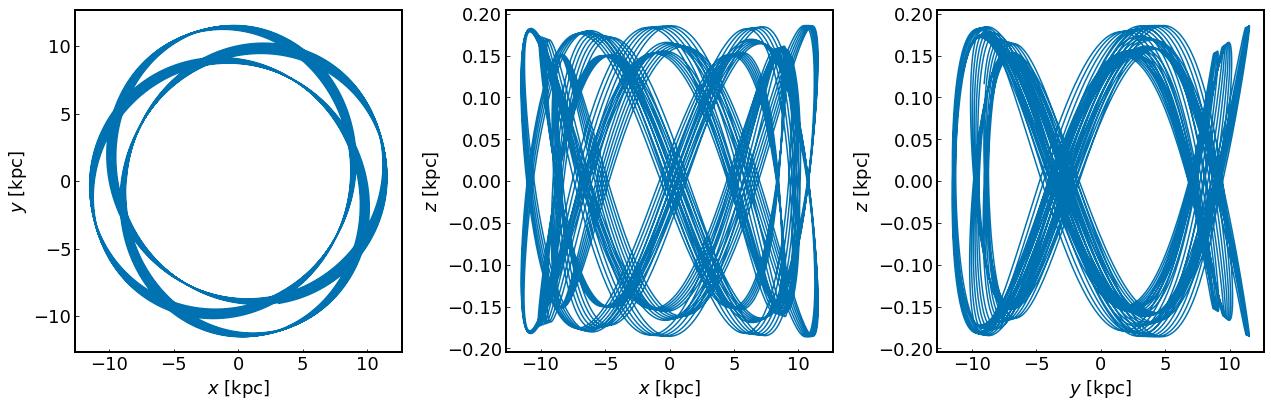

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

times, orbit = orbits[16]

axes[0].plot(orbit[:, 0], orbit[:, 1])
axes[1].plot(orbit[:, 0], orbit[:, 2])
axes[2].plot(orbit[:, 1], orbit[:, 2])

axes[0].set_xlabel(r'$x$ [kpc]')
axes[1].set_xlabel(r'$x$ [kpc]')
axes[2].set_xlabel(r'$y$ [kpc]')
axes[0].set_ylabel(r'$y$ [kpc]')
axes[1].set_ylabel(r'$z$ [kpc]')
axes[2].set_ylabel(r'$z$ [kpc]')

fig.tight_layout()

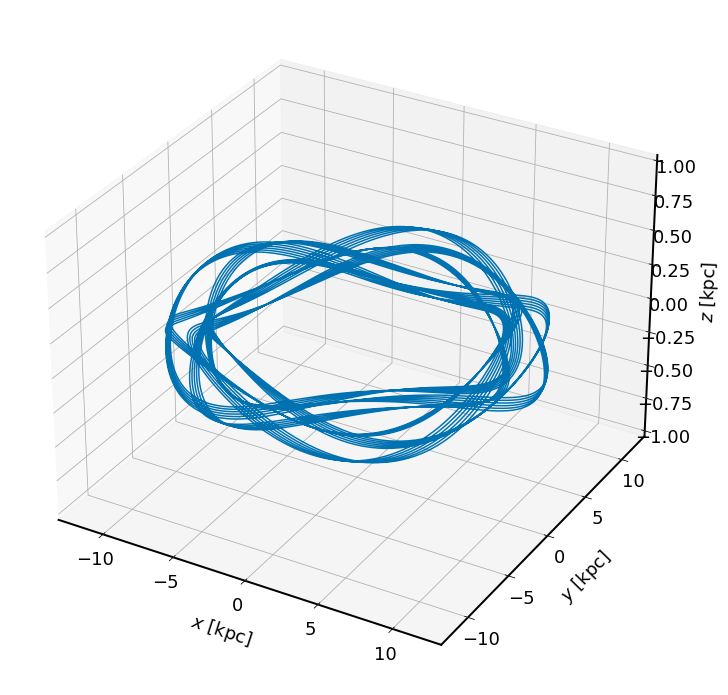

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

times, orbit = orbits[16]

ax.plot3D(orbit[:, 0], orbit[:, 1], orbit[:, 2])
ax.set_xlabel(r'$x$ [kpc]', labelpad=15)
ax.set_ylabel(r'$y$ [kpc]', labelpad=15)
ax.set_zlabel(r'$z$ [kpc]', labelpad=15)
ax.set_zlim3d(-1, 1)

fig.tight_layout()

## 2. Calculate the cylindrical action with Agama

For systems with an azimuthal symmetry like the Milky Way, it is useful to work in cylindrical coordinates $(R, \phi, z)$, where $R$ is the cylindrical radius, $z$ is the height, and $\phi$ is the azimuthal angle.
Therefore, we will be calculating the cylindrical action variables $(J_r, J_\phi, J_z)$.

In [ ]:
# Create an action finder from the potential to calculate the action
action_finder = agama.ActionFinder(potential)

In [ ]:
def plot_action(Jr, Jz, Jphi, hist_range, bins=100, norm=None):
    ''' Plot the 2d distribution of the actions'''
    
    if norm is None:
        norm = mpl.colors.LogNorm(vmin=1, vmax=100)    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].hist2d(
        Jphi, Jr, bins=(bins, bins), range=(hist_range[2], hist_range[0]), norm=norm)
    axes[1].hist2d(
        Jphi, Jz, bins=(bins, bins), range=(hist_range[2], hist_range[1]), norm=norm)
    axes[2].hist2d(
        Jr, Jz, bins=(bins, bins), range=(hist_range[0], hist_range[1]), norm=norm)

    axes[0].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_xlabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[0].set_ylabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[1].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    axes[2].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
    fig.tight_layout()
    
    return fig, axes

### Example: Action of a random box of stars

In [ ]:
# Generate a random box of stars
N = 100000
pos = np.random.uniform([0, 0, 0], [20, 20, 20], size=(N, 3))
vel = np.random.uniform([0, 0, 0], [200, 200, 200], size=(N, 3))
posvel = np.hstack([pos, vel])

# Calculate the action
# NOTE: Agama returns the action in order of Jr, Jz, Jphi
Jr, Jz, Jphi = action_finder(posvel).T

In [ ]:
hist_range = ((0, 8000), (0, 5000), (-5000, 5000))
bins = 100
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
fig, axes = plot_action(Jr, Jz, Jphi, hist_range, bins, norm)

### Example: Action of a rotating disk

In [ ]:
# Generate a random box of stars
N = 100000

# Create a disk that extends radially from 1 to 10 kpc
# and height from -50 to 50 pc
r = np.random.uniform(6, 10, size=N)
z = np.random.uniform(-0.05, 0.05, size=N)
phi = np.random.uniform(0, 2*np.pi, size=N)
vr = np.random.uniform(-10, 10, size=N)
vz = np.random.uniform(-10, 10, size=N)
vphi = np.random.uniform(240, 260, size=N)

# Convert coordinates into Cartesian
x = r * np.cos(phi)
y = r * np.sin(phi)
vx = vr * np.cos(phi) - vphi * np.sin(phi)
vy = vr * np.sin(phi) + vphi * np.cos(phi)

# Calculate the action
posvel = np.stack([x, y, z, vx, vy, vz], 1)
Jr, Jz, Jphi = action_finder(posvel).T

In [ ]:
hist_range = ((0, 200), (0, 1), (-3000, 3000))
bins = 100
norm = mpl.colors.LogNorm(vmin=1, vmax=1000)
fig, axes = plot_action(Jr, Jz, Jphi, hist_range, bins, norm)

### Example: Actions of accreted stars

In [ ]:
Jr, Jz, Jphi = action_finder(posvel_accreted).T

In [ ]:
# Because there are only 100 stars in the test data,
# we will plot the sactter plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(Jphi, Jr)
axes[1].scatter(Jphi, Jz)
axes[2].scatter(Jr, Jphi)

axes[0].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
axes[1].set_xlabel(r' $J_\phi [\mathrm{kpc} \, \mathrm{km} \mathrm{s}^{-1}]$')
axes[2].set_xlabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
axes[0].set_ylabel(r' $J_r [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
axes[1].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')
axes[2].set_ylabel(r' $J_z [\mathrm{kpc}  \, \mathrm{km} \mathrm{s}^{-1}]$')

fig.tight_layout()